# Background creation and parameter exploration

## Explored
- Creation of a flat background/seq
- Influencial parameters in creating a flat background/seq

## Goal
- Obtain a standard set of parameters for creating a flat seq.

In [1]:
# Importing libraries

from basenji import dataset, seqnn, dna_io,stream
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO
import seaborn as sns
import akita_utils 
import tensorflow as tf
import pysam
import h5py

# Getting genomic data

In [2]:
genome_fasta = '/project/fudenber_735/genomes/mm10/mm10.fa'
genome_open = pysam.Fastafile(genome_fasta)

# Loading akita model

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
print(tf.__version__)

head_i = 1 #mouse
model_num = 1 #which fold to use

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models/'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.4.1


2022-11-15 16:36:22.436294: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


built
restored


(512, 130305, (130305,))

# Fetching chromosome data to explore background creation

In [4]:
chromsizes = bioframe.read_chromsizes('/project/fudenber_735/tensorflow_models/akita/v2/data/mm10/sequences.bed')
dframe = pd.DataFrame(chromsizes)
dframe['end'] = dframe['length']+ 1310720
dframe = dframe.reset_index()
dframe.rename(columns = {'index' : 'chrom', 'length':'start'}, inplace = True)
df = bioframe.frac_gc(dframe, bioframe.load_fasta('/project/fudenber_735/genomes/mm10/mm10.fa'), return_input=True)

df

,chrom,start,end,GC
0,chr1,40415232,41725952,0.407777
1,chr1,42708992,44019712,0.424985
2,chr1,42053632,43364352,0.424847
3,chr1,41725952,43036672,0.411407
4,chr1,43036672,44347392,0.417725
...,...,...,...,...
6033,chrX,99241984,100552704,0.424162
6034,chrX,120532992,121843712,0.367963
6035,chrX,139360256,140670976,0.407839
6036,chrX,128737280,130048000,0.370827


In [5]:
# visualizing the gc content distribution

# plt.hist( df['GC'].values, 100);
# np.percentile(df['GC'].dropna().values, np.linspace(1,99,5))

# Generating a sample for down stream analysis

In [6]:
super_set = []
error = 0.0001

for gc in np.percentile(df['GC'].dropna().values, np.linspace(1,99,5)):
    for i in range(df.shape[0]):
        if gc-error <= df['GC'].values[i] <= gc+error:
            super_set += [i]
            break

super_set = list(set(super_set)); print(f'Whole distribution: {super_set}')
sample_set = super_set; print(f'Sampled datapoints: {sample_set}')

Whole distribution: [1216, 274, 18, 1076, 600]
Sampled datapoints: [1216, 274, 18, 1076, 600]


# Making predictions for the sampled data

In [7]:
predictions=[]

for ind in set(sample_set):
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    genome_open = pysam.Fastafile(genome_fasta)
    seq = genome_open.fetch(chrom, start, end).upper()
    seq_1hot = dna_io.dna_1hot(seq)
    predictions.append(seq_1hot)
    
predictions = np.array(predictions)
predictions = seqnn_model.predict(predictions, batch_size=6)

2022-11-15 16:37:29.302852: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-15 16:37:29.303230: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2595180000 Hz


# Creating flat backroung seqs from sampled data

In [8]:
# Paramaters for all analysis downstream
max_iters = 10
batch_size = 5
shuffle_k = 8 
ctcf_thresh = 8 
scores_thresh = 5500 
scores_pixelwise_thresh = .05
new_dataframe = df.iloc[[ind for ind in set(sample_set)]]
# ---------------------------------------------------------------

# For comparison further down
shuffle_set = [2,4,8] # shuffling basepairs to sample for comparison
ctcf_thresh_set = [8,15,30] # number of ctcf motifs to sample for comparison

In [9]:
flat_seqs = akita_utils.create_flat_seqs(seqnn_model=seqnn_model, 
                                        genome_fasta=genome_fasta, 
                                        seq_length=seq_length, 
                                        dataframe=new_dataframe, 
                                        max_iters = max_iters, 
                                        batch_size = batch_size, 
                                        shuffle_k = shuffle_k, 
                                        ctcf_thresh = ctcf_thresh, 
                                        scores_thresh = scores_thresh, 
                                        scores_pixelwise_thresh = scores_pixelwise_thresh )

ind 0 , iter  0 , for chr3 71278592 72589312
trying: best seq, thresh 7308.0  pixelwise 0.05222
ind 0 , iter  1 , for chr3 71278592 72589312
trying: best seq, thresh 6996.0  pixelwise 0.05215
ind 0 , iter  2 , for chr3 71278592 72589312
success: best seq, thresh 7636.0  pixelwise 0.0422 time 15.54378056526184
max iters exceeded, final time 15.54378056526184
ind 1 , iter  0 , for chr1 158789632 160100352
trying: best seq, thresh 6756.0  pixelwise 0.0694
ind 1 , iter  1 , for chr1 158789632 160100352
success: best seq, thresh 7264.0  pixelwise 0.04984 time 9.819923639297485
max iters exceeded, final time 9.819923639297485
ind 2 , iter  0 , for chr1 36810752 38121472
trying: best seq, thresh 13380.0  pixelwise 0.1028
ind 2 , iter  1 , for chr1 36810752 38121472
trying: best seq, thresh 17090.0  pixelwise 0.2349
ind 2 , iter  2 , for chr1 36810752 38121472
trying: best seq, thresh 8310.0  pixelwise 0.0989
ind 2 , iter  3 , for chr1 36810752 38121472
trying: best seq, thresh 9900.0  pixelwi

/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


trying: best seq, thresh 17220.0  pixelwise 0.2306
ind 4 , iter  8 , for chr2 27127808 28438528
trying: best seq, thresh 11544.0  pixelwise 0.1735
ind 4 , iter  9 , for chr2 27127808 28438528
trying: best seq, thresh 16056.0  pixelwise 0.2473
max iters exceeded, final time 49.88376045227051


# Visualizing the created flat seqs' contact maps

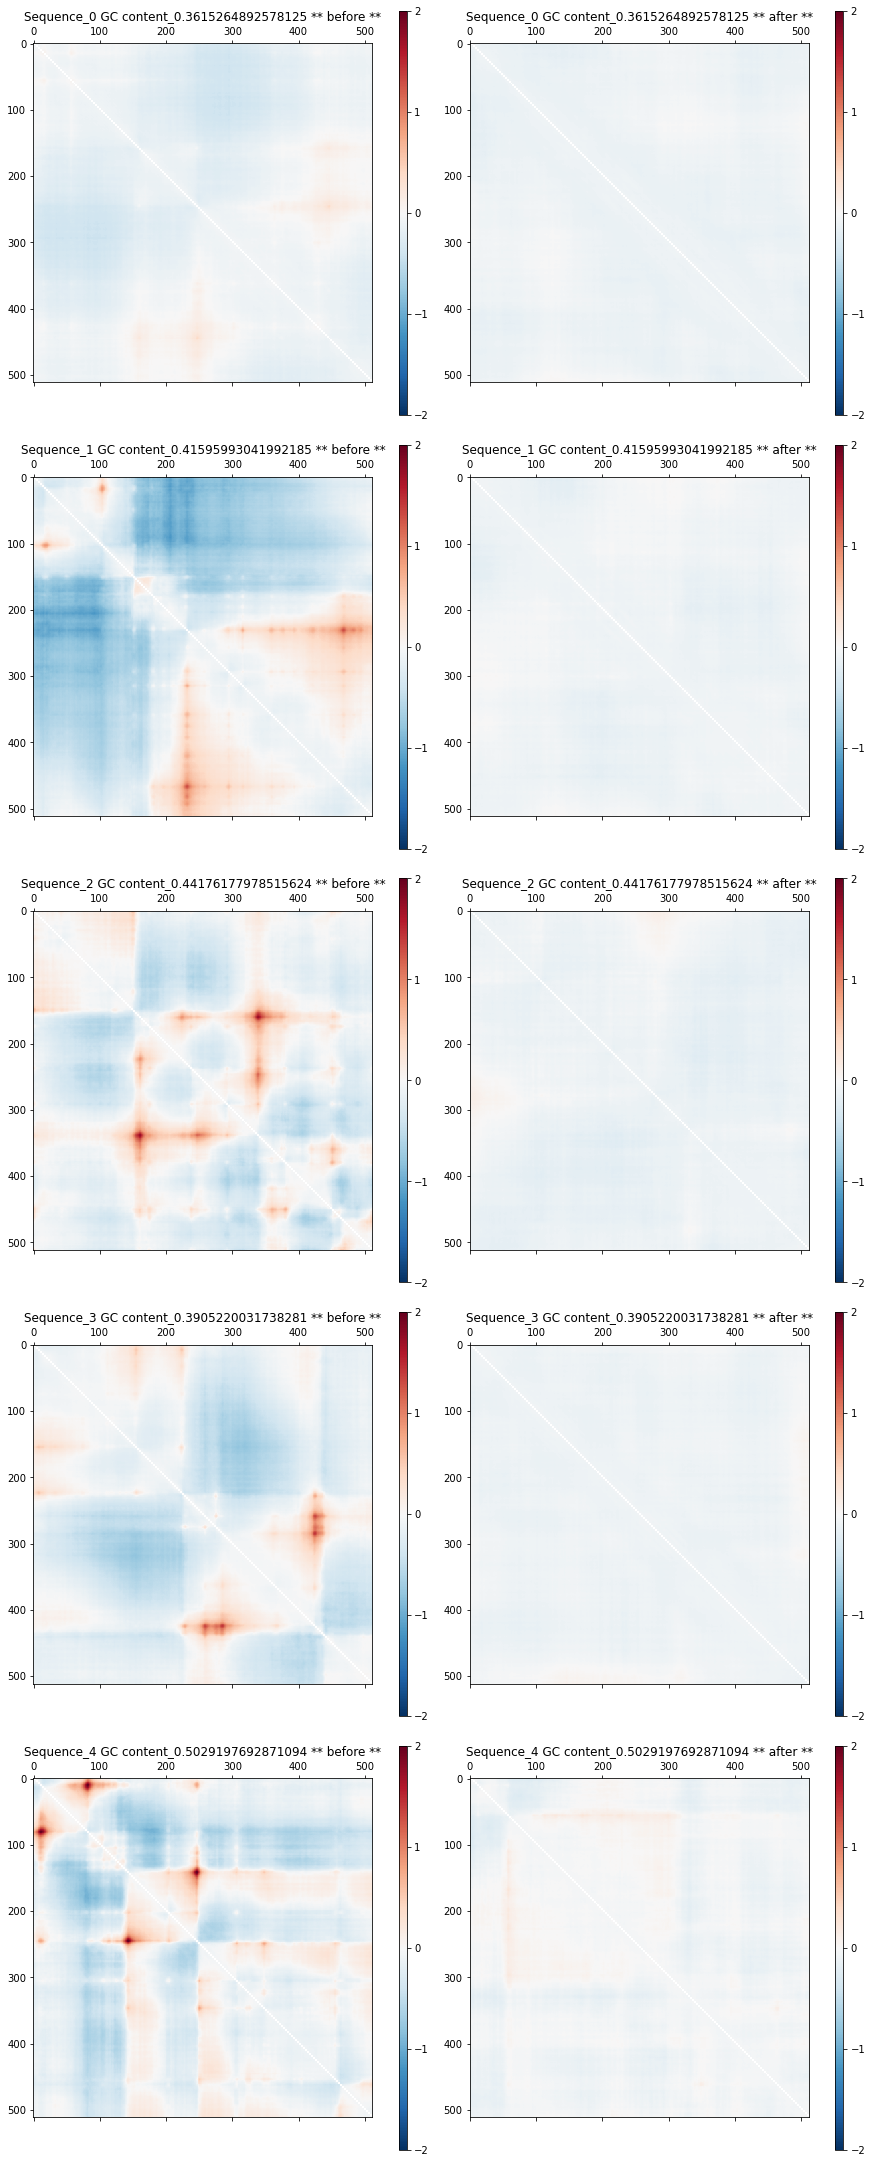

In [10]:
fig = plt.figure(figsize=(6* 2 , 6 *  len(sample_set) ), constrained_layout=True)     
spec = fig.add_gridspec(ncols=2, nrows=len(sample_set), hspace=0.1, wspace=0.1)#
           
target_ind = 0
vmin=-2; vmax=2

for i in range(len(sample_set)):
    
    flat_pred = flat_seqs[i][1]
    gc        = flat_seqs[i][-1]
    back_pred = predictions[i]

    mat = akita_utils.from_upper_triu(back_pred[:,target_ind], target_map_size,hic_diags)
    ax1 = fig.add_subplot(spec[i,0])
    im = ax1.matshow(mat, cmap='RdBu_r', vmin=vmin, vmax=vmax)# 
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])
    plt.title(f'Sequence_{i} GC content_{gc} ** before **')       
           
    mat = akita_utils.from_upper_triu(flat_pred[:,target_ind], target_map_size,hic_diags)
    ax2 = fig.add_subplot(spec[i,1])
    im = ax2.matshow(mat, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])       
    plt.title(f'Sequence_{i} GC content_{gc} ** after **')       
        
plt.show()

# General distribution of scores

In [11]:
scores_before = {}

for gc in sample_set:
    new_dataframe = df.iloc[[gc]]
    for k in shuffle_set:
        print(gc,k)
        scores_before[gc,k] = akita_utils.custom_calculate_scores(  seqnn_model=seqnn_model, 
                                                                    genome_fasta=genome_fasta, 
                                                                    seq_length=seq_length, 
                                                                    dataframe=new_dataframe, 
                                                                    max_iters = max_iters, 
                                                                    batch_size = batch_size, 
                                                                    shuffle_k = k, 
                                                                    ctcf_thresh = ctcf_thresh, 
                                                                    scores_thresh = scores_thresh,
                                                                    scores_pixelwise_thresh = scores_pixelwise_thresh)
        
# scores_before

1216 2
ind 0 , iter  0 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  1 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  2 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  3 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  4 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  5 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  6 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  7 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  8 ,k  2 , for chr3 71278592 72589312
ind 0 , iter  9 ,k  2 , for chr3 71278592 72589312
max iters exceeded
1216 4
ind 0 , iter  0 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  1 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  2 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  3 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  4 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  5 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  6 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  7 ,k  4 , for chr3 71278592 72589312
ind 0 , iter  8 ,k  4 , for chr3 71278592 7258931

/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ind 0 , iter  1 ,k  2 , for chr1 158789632 160100352
ind 0 , iter  2 ,k  2 , for chr1 158789632 160100352
ind 0 , iter  3 ,k  2 , for chr1 158789632 160100352
ind 0 , iter  4 ,k  2 , for chr1 158789632 160100352
ind 0 , iter  5 ,k  2 , for chr1 158789632 160100352
ind 0 , iter  6 ,k  2 , for chr1 158789632 160100352
ind 0 , iter  7 ,k  2 , for chr1 158789632 160100352
ind 0 , iter  8 ,k  2 , for chr1 158789632 160100352
ind 0 , iter  9 ,k  2 , for chr1 158789632 160100352
max iters exceeded
274 4
ind 0 , iter  0 ,k  4 , for chr1 158789632 160100352
ind 0 , iter  1 ,k  4 , for chr1 158789632 160100352
ind 0 , iter  2 ,k  4 , for chr1 158789632 160100352
ind 0 , iter  3 ,k  4 , for chr1 158789632 160100352
ind 0 , iter  4 ,k  4 , for chr1 158789632 160100352
ind 0 , iter  5 ,k  4 , for chr1 158789632 160100352
ind 0 , iter  6 ,k  4 , for chr1 158789632 160100352
ind 0 , iter  7 ,k  4 , for chr1 158789632 160100352
ind 0 , iter  8 ,k  4 , for chr1 158789632 160100352
ind 0 , iter  9 ,k  4

/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ind 0 , iter  1 ,k  2 , for chr1 36810752 38121472
ind 0 , iter  2 ,k  2 , for chr1 36810752 38121472
ind 0 , iter  3 ,k  2 , for chr1 36810752 38121472
ind 0 , iter  4 ,k  2 , for chr1 36810752 38121472
ind 0 , iter  5 ,k  2 , for chr1 36810752 38121472
ind 0 , iter  6 ,k  2 , for chr1 36810752 38121472
ind 0 , iter  7 ,k  2 , for chr1 36810752 38121472
ind 0 , iter  8 ,k  2 , for chr1 36810752 38121472
ind 0 , iter  9 ,k  2 , for chr1 36810752 38121472
max iters exceeded
18 4
ind 0 , iter  0 ,k  4 , for chr1 36810752 38121472
ind 0 , iter  1 ,k  4 , for chr1 36810752 38121472
ind 0 , iter  2 ,k  4 , for chr1 36810752 38121472
ind 0 , iter  3 ,k  4 , for chr1 36810752 38121472
ind 0 , iter  4 ,k  4 , for chr1 36810752 38121472
ind 0 , iter  5 ,k  4 , for chr1 36810752 38121472
ind 0 , iter  6 ,k  4 , for chr1 36810752 38121472
ind 0 , iter  7 ,k  4 , for chr1 36810752 38121472
ind 0 , iter  8 ,k  4 , for chr1 36810752 38121472
ind 0 , iter  9 ,k  4 , for chr1 36810752 38121472
max ite

/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ind 0 , iter  9 ,k  8 , for chr2 27127808 28438528
max iters exceeded


# Visualing the scores' distribution for the created flat seqs

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to pu

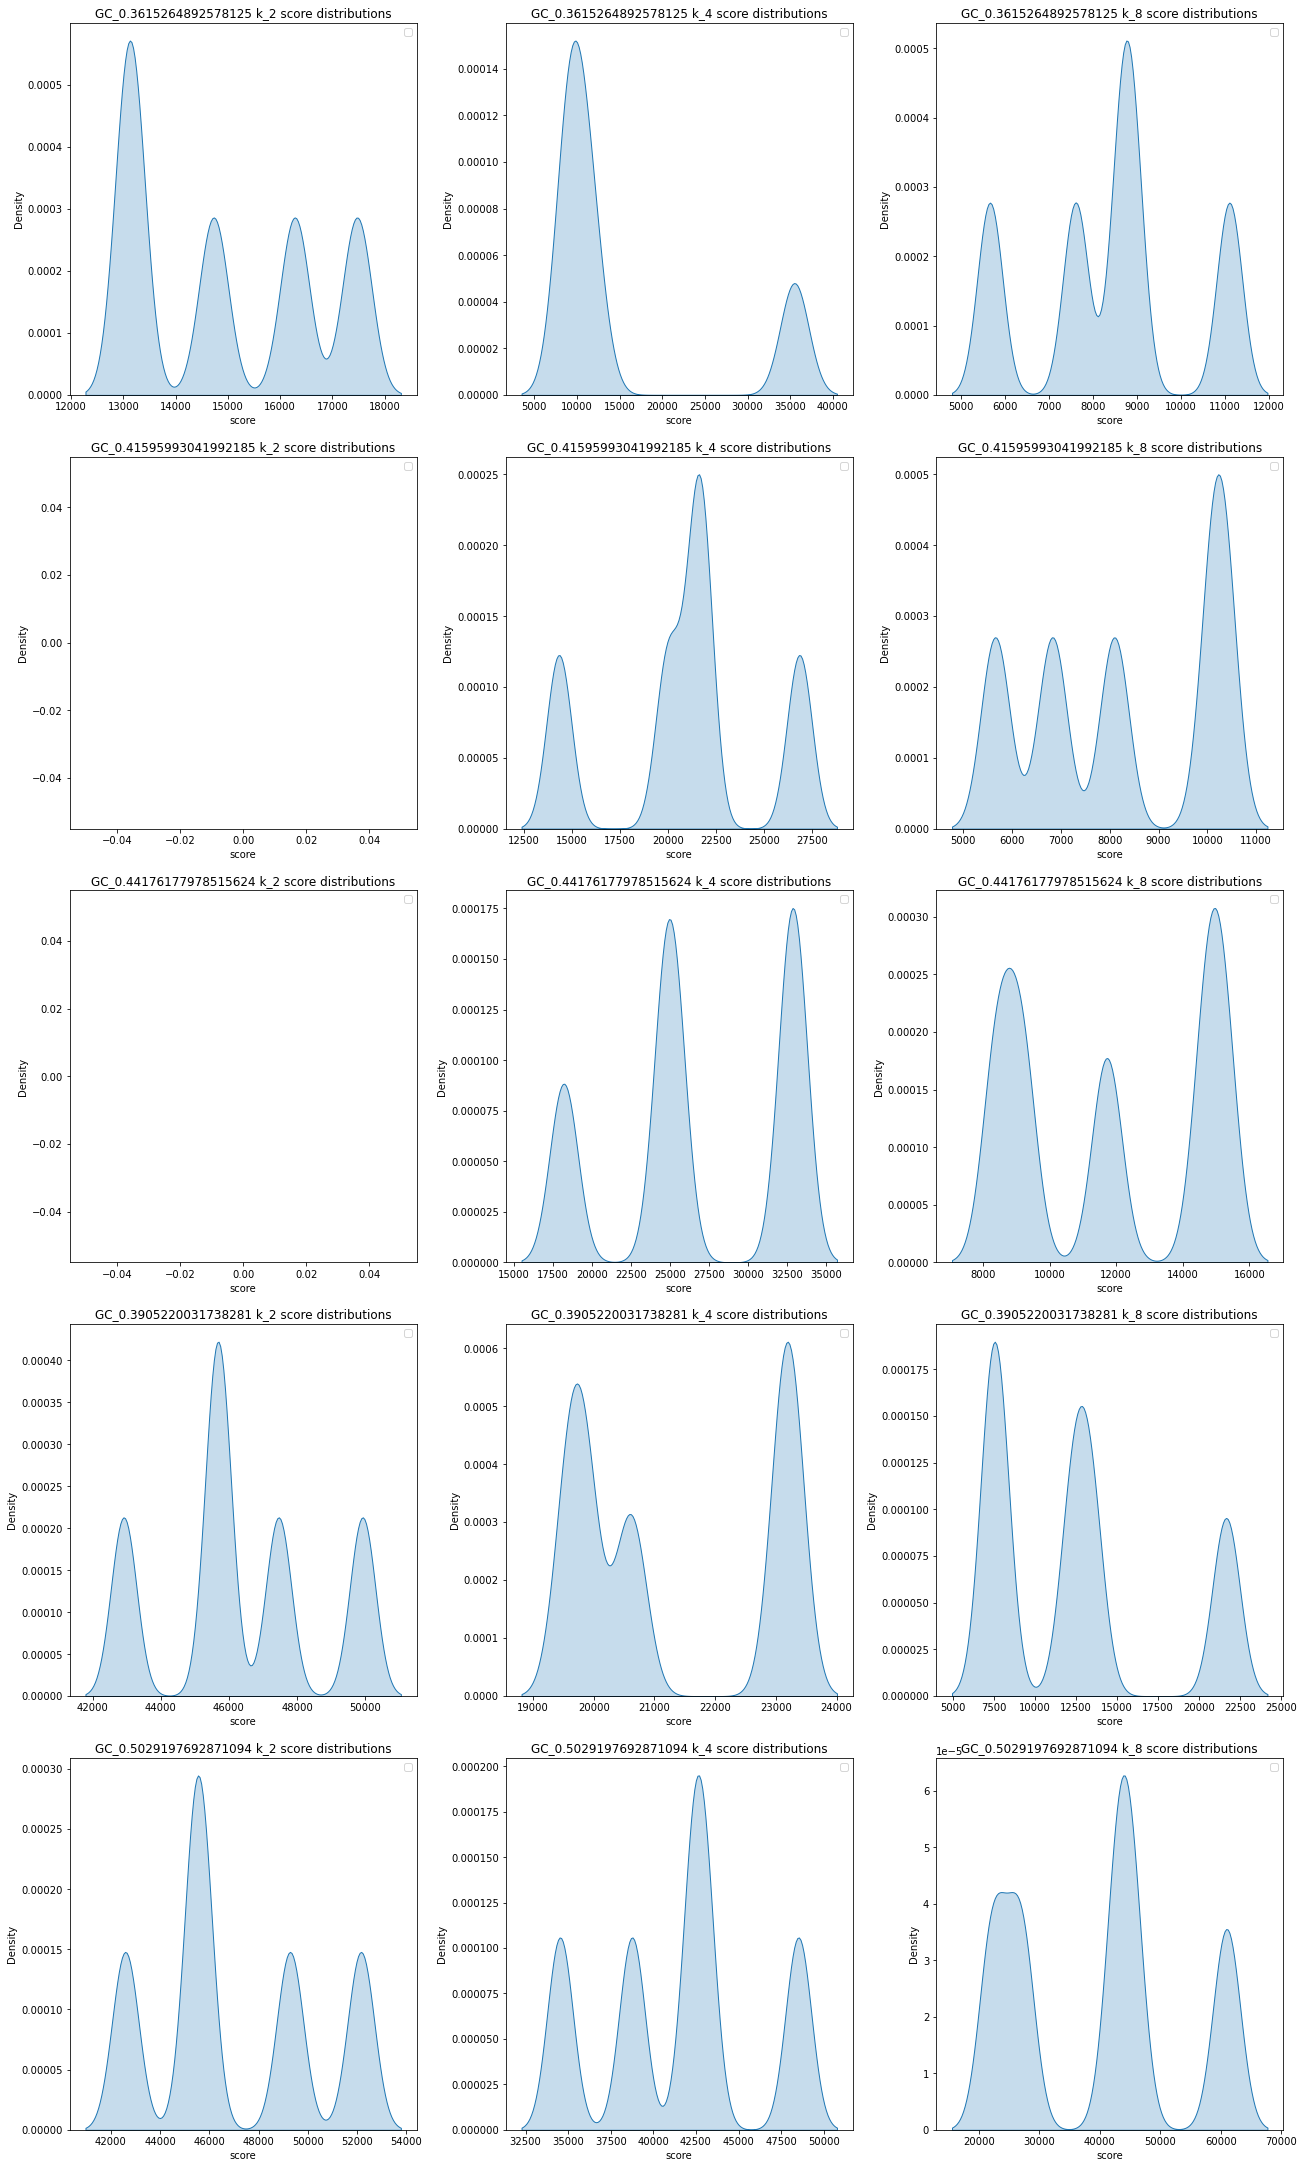

In [12]:
fig = plt.figure(figsize=(6* len(shuffle_set) , 6 *  len(sample_set) ), constrained_layout=True)     
spec = fig.add_gridspec(ncols=len(shuffle_set), nrows=len(sample_set), hspace=0.1, wspace=0.1)
           
for ind in sample_set:
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    for k in shuffle_set:
        ax1 = fig.add_subplot(spec[sample_set.index(ind),shuffle_set.index(k)])
        
        temp_scores_before = []
        for i in scores_before[ind,k]:
            temp_scores_before =+ i
        
        kde_df_before = pd.DataFrame(temp_scores_before, columns=["score"])
        sns.kdeplot(data=kde_df_before, x="score", bw_adjust=.2, fill=True)
        
        plt.title(f'GC_{gc} k_{k} score distributions')
        plt.legend()

plt.show()
plt.close()

# Some observations

With a threshold of 6000;

As the gc content lowers, scores below threshold are obtained in k=8, some low scores can be obtained in the k=4,2. For really low gc content, more low scores can be obtained for k=4.

This implies k=8 is the best option over a wide range of gc content distribution and thus will be used futher on.

In [13]:
shuffle_set = [8]

# Now we focus on how to maskout some CTCF motifs to lower the structure in our maps (this is discussed in detail in the mutation method notebook)


# Some observations

There are three ways to go about this;
- just randomly shuffle the whole seq
- scan for CTCF and randomly shuffle the motifs
- scan for CTCF and manually shuffle the motifs

## RESULTS
In terms of scores, all these cases tend to produce the same distribution.
In terms of time to a successfull iteration, there are slight differences as observed  in the mutation method notebook. This could be very much dependent on the GC content of the seq under investigation.

# Now we try different thresholds to the minimum CTCF motifs in a seq above which we start the shuffling process (ctcf_thresh)


In [14]:
ctcf_thresh_after = {}

for gc in sample_set:
    new_dataframe = df.iloc[[gc]]
    for score in ctcf_thresh_set:
        print(gc,score)
        ctcf_thresh_after[gc,score] = akita_utils.custom_calculate_scores(seqnn_model = seqnn_model, 
                                                            genome_fasta = genome_fasta, 
                                                            seq_length = seq_length, 
                                                            dataframe = new_dataframe, 
                                                            max_iters = max_iters, 
                                                            batch_size = batch_size, 
                                                            shuffle_k = 8, 
                                                            ctcf_thresh = score,#ctcf_thresh, 
                                                            scores_thresh = scores_thresh,#score, 
                                                            scores_pixelwise_thresh = scores_pixelwise_thresh,
                                                            success_scores = 1,                
                                                            masking = True)

1216 8
ind 0 , iter  0 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 7184.0  pixelwise 0.03738 ***
ind 0 , iter  1 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 5710.0  pixelwise 0.04575 ***
ind 0 , iter  2 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 6132.0  pixelwise 0.04022 ***
ind 0 , iter  3 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 6600.0  pixelwise 0.05322
ind 0 , iter  4 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 6224.0  pixelwise 0.04276 ***
ind 0 , iter  5 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 5696.0  pixelwise 0.04175 ***
ind 0 , iter  6 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 5624.0  pixelwise 0.0445 ***
ind 0 , iter  7 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 5652.0  pixelwise 0.04016 ***
ind 0 , iter  8 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 6120.0  pixelwise 0.03946 ***
ind 

# Visualing the scores' distribution for the created seqs

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


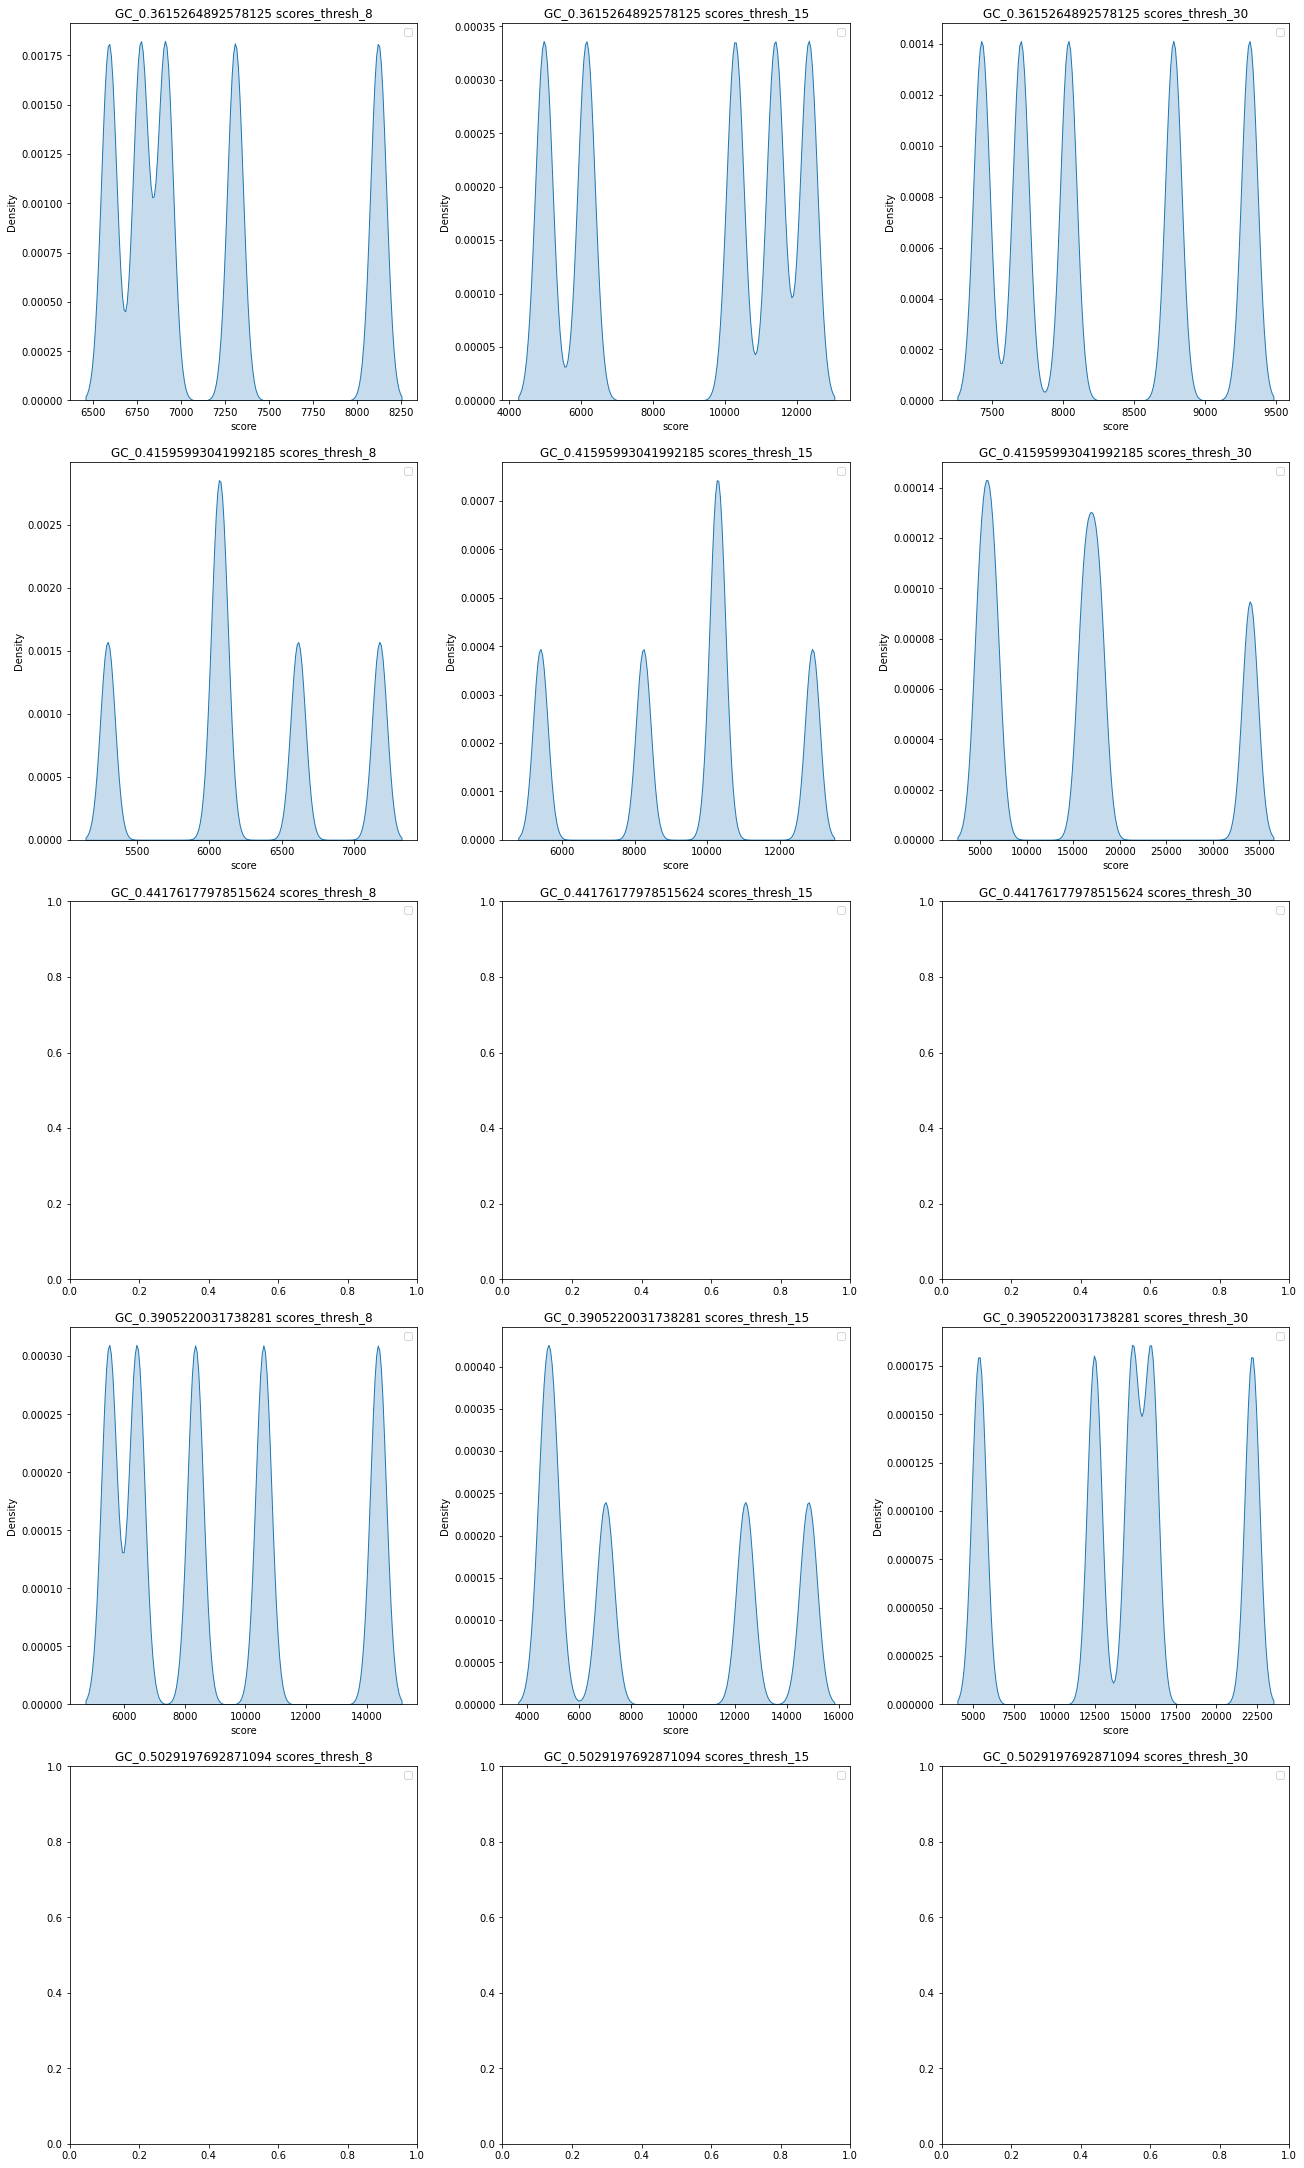

In [15]:
fig1 = plt.figure(figsize=(6* len(ctcf_thresh_set) , 6 *  len(sample_set) ), constrained_layout=True)     
spec1 = fig1.add_gridspec(ncols=len(ctcf_thresh_set), nrows=len(sample_set), hspace=0.1, wspace=0.1)#
           
for ind in sample_set:
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    for score in ctcf_thresh_set:
        ax1 = fig1.add_subplot(spec1[sample_set.index(ind),ctcf_thresh_set.index(score)])
        
        temp_ctcf_thresh_after = []
        for i in ctcf_thresh_after[ind,score]:
            temp_ctcf_thresh_after =+ i
        
        kde_df_after = pd.DataFrame(temp_ctcf_thresh_after, columns=["score"])
        sns.kdeplot(data=kde_df_after, x="score", bw_adjust=.1, fill=True)
        ax1.legend()        
        plt.title(f'GC_{gc} scores_thresh_{score}')

plt.show()
plt.close()

# Some observations


For high gc content and low threshold, there is no success.  As the gc content lowers, some success can be obtained in higher thresholds. For really low gc content, more success can be obtained for lower thresholds.

This implies that to create a background seq, you need a reasonably low gc content and threshold.

# Now we focus on effect of masking to basepairs shuffled.  

In [16]:
ctcf_shuffle_after = {}

for gc in sample_set:
    new_dataframe = df.iloc[[gc]]
    for k in shuffle_set:
        print(gc,k)
        ctcf_shuffle_after[gc,k] = akita_utils.custom_calculate_scores(seqnn_model = seqnn_model, 
                                                                    genome_fasta = genome_fasta, 
                                                                    seq_length = seq_length, 
                                                                    dataframe = new_dataframe, 
                                                                    max_iters = max_iters, 
                                                                    batch_size = batch_size, 
                                                                    shuffle_k = k, 
                                                                    ctcf_thresh = ctcf_thresh, 
                                                                    scores_thresh = scores_thresh, 
                                                                    scores_pixelwise_thresh = scores_pixelwise_thresh,
                                                                    success_scores = 1,
                                                                    masking = False)

1216 8
ind 0 , iter  0 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 7136.0  pixelwise 0.05435
ind 0 , iter  1 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 5890.0  pixelwise 0.08075
ind 0 , iter  2 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 8510.0  pixelwise 0.075
ind 0 , iter  3 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 7936.0  pixelwise 0.0543
ind 0 , iter  4 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 5430.0  pixelwise 0.04764 ***
ind 0 , iter  5 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 9256.0  pixelwise 0.05984
ind 0 , iter  6 ,k  8 , for chr3 71278592 72589312
*** success: best seq, thresh 7500.0  pixelwise 0.04553 ***
ind 0 , iter  7 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 8880.0  pixelwise 0.0823
ind 0 , iter  8 ,k  8 , for chr3 71278592 72589312
trying: best seq, thresh 6650.0  pixelwise 0.05923
ind 0 , iter  9 ,k  8 , for chr3 71278592 72589312
*** succes

# Visualizing the resultant score distributions.

NameError: name 'scores_shuffle_after' is not defined

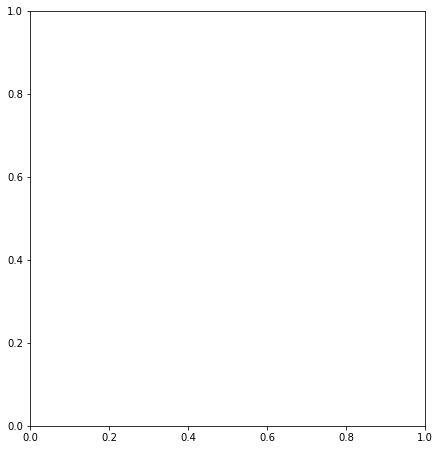

In [17]:
fig = plt.figure(figsize=(6* len(shuffle_set) , 6 *  len(sample_set) ), constrained_layout=True)     
spec = fig.add_gridspec(ncols=len(shuffle_set), nrows=len(sample_set), hspace=0.1, wspace=0.1)
           
for ind in sample_set:
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    for k in shuffle_set:
        ax1 = fig.add_subplot(spec[sample_set.index(ind),shuffle_set.index(k)])
        # plt.hist(scores_after[gc,k],5)
        
        temp_scores_shuffle_after = []
        for i in scores_shuffle_after[ind,k]:
            temp_scores_shuffle_after =+ i
            
        temp_scores_before = []
        for i in scores_before[ind,k]:
            temp_scores_before =+ i
        
        kde_df_after = pd.DataFrame(temp_scores_shuffle_after, columns=["score"])
        kde_df_before = pd.DataFrame(temp_scores_before, columns=["score"])
        sns.kdeplot(data=kde_df_after, x="score", bw_adjust=.1, label='after',fill=True)
        sns.kdeplot(data=kde_df_before, x="score", bw_adjust=.1, label='before',fill=True)#
        ax1.legend()
        plt.title(f'GC_{gc} k_{k} before and after masking')
plt.show()
plt.close()

# Final observations

The first parameter for focus when desighing a background seq is the gc content of the initial seq.
Seq with lower gc are preffeerd

The second parameter is the shuffling basepairs, 8 are prefferd

Third is whether masking is necessary. According to preliminary results, the difference in the timing seems to be minimal but further analysis is underway.